### Building a Binary Classifier using the USDA's Food Atlas

# Table of Contents

* [Introduction](#introduction)
* [Obtaining Data](#obtaining)
* [Scrubbing Data](#scrubbing)
* [Exploratory Data Analysis](#exploratory)
    * [Feature Ranking](#feature)
    * [Further Exploration](#further)
* [Building a Classifier](#building)
* [Wrap-Up](#wrap)
    * [Recommendations](#recommendations)
    * [Possible Next Steps](#possible)

# Introduction<a name="introduction"></a>

In this project, I used data on food access from the USDA's Food Environment Atlas to predict whether each US county would qualify as a part of the Diabetes Belt, which is a area in the southwest of United States where the rate of adult type II diabetes is especially high. I conceived of this project as an opportunity to practice creating a machine learning classifier on a topic of social relevance.

In order to qualify as a part of the Diabetes Belt, a US County must have an adult diabetes rate of 11% or higher. The CDC made this designation based off of data from 2008. I will be attempting to predict the counties that would be a part of the belt in 2013, which is the most recent publicly downloadable data on adult diabetes.

# Obtaining Data<a name="obtaining"></a>

The data is fortunately available in a single Excel file on the USDA's website:

https://www.ers.usda.gov/data-products/food-environment-atlas/data-access-and-documentation-downloads/

Different categories of data are distributed across six different sheets, but as each row is a US county with an unique FIPS code, it was simple to combine into a single pandas DataFrame.

In [2]:
def read(file):
    excel = pd.ExcelFile(file)
    sheets = excel.sheet_names[4:]

    dataframes = [excel.parse(sheet_name=sheet) for sheet in sheets]

    df = reduce(lambda left,right: pd.merge(left,right,on='FIPS'), dataframes)

    return df

In [3]:
data = read('food_atlas.xls')
data.shape

(3143, 296)

In [4]:
data.head()

,FIPS,State_x,County_x,LACCESS_POP10,LACCESS_POP15,PCH_LACCESS_POP_10_15,PCT_LACCESS_POP10,PCT_LACCESS_POP15,LACCESS_LOWI10,LACCESS_LOWI15,...,PCT_NHPI10,PCT_65OLDER10,PCT_18YOUNGER10,MEDHHINC15,POVRATE15,PERPOV10,CHILDPOVRATE15,PERCHLDPOV10,METRO13,POPLOSS10
0,1001,AL,Autauga,18428.439685,17496.693038,-5.056026,33.769657,32.062255,5344.427472,6543.676824,...,0.040314,11.995382,26.777959,56580.0,12.7,0,18.8,0,1,0.0
1,1003,AL,Baldwin,35210.814078,30561.264430,-13.204891,19.318473,16.767489,9952.144027,9886.831137,...,0.043343,16.771185,22.987408,52387.0,12.9,0,19.6,0,1,0.0
2,1005,AL,Barbour,5722.305602,6069.523628,6.067799,20.840972,22.105560,3135.676086,2948.790251,...,0.087409,14.236807,21.906982,31433.0,32.0,1,45.2,1,0,0.0
3,1007,AL,Bibb,1044.867327,969.378841,-7.224696,4.559753,4.230324,491.449066,596.162829,...,0.030548,12.681650,22.696923,40767.0,22.2,0,29.3,1,1,0.0
4,1009,AL,Blount,1548.175559,3724.428242,140.568857,2.700840,6.497380,609.027708,1650.959482,...,0.031402,14.722096,24.608353,50487.0,14.7,0,22.2,0,1,0.0


# Scrubbing Data<a name="scrubbing"></a>

The combined DataFrame had 296 features, many of which duplicated information or had missing entries. I performed the following operations to scrub the data clean (dropped measurements in bold):

1. The **State and County** features were not appropriate for use in the classifier, so these I dropped. I stored the FIPS codes in a separate list for graphing purposes.
2. For every feature recorded as a **raw count**, the USDA conveniently provided either a normalized or scaled version. This left me free to drop all of the raw counts.
3. Wherever there were **multiple years of measurements**, I kept only the most recent year, 2013 or prior.
4. While features showing the **change from one year's measurement to the next** could have been interesting transformed into a categorical feature (i.e. positive change, negative change, no change), for the scope of the project I elected to drop these features. It could be a fruitful area of exploration, however.
5. Finally, I dropped all columns containing **null values**. Because each row is a county, any leniency here would rob us of crucial data.

After the scrubbing step, I was left with a much more manageable selection of 37 features, including the target.

In [8]:
df.head()

,PCT_DIABETES_ADULTS13,PCT_65OLDER10,GROCPTH09,PCT_LACCESS_POP10,PCT_WIC09,PCT_SFSP09,PCT_LACCESS_HHNV10,SNAP_OAPP09,PCT_LACCESS_LOWI10,SNAPSPTH12,...,PCT_NSLP09,PCT_NHWHITE10,PCT_NHPI10,CONVSPTH09,SNAP_PART_RATE13,PCT_NHBLACK10,PCT_SBP09,SNAP_REPORTSIMPLE09,PCT_NHNA10,SNAP_CAP09
0,13.0,11.995382,0.110834,33.769657,2.990417,0.56489,3.284786,0.0,9.793530,0.674004,...,12.315055,77.246156,0.040314,0.535698,89.184,17.582599,4.509008,1,0.397647,0
1,10.4,16.771185,0.133775,19.318473,2.990417,0.56489,2.147827,0.0,5.460261,0.725055,...,12.315055,83.504787,0.043343,0.663300,89.184,9.308425,4.509008,1,0.628755,0
2,18.4,14.236807,0.180786,20.840972,2.990417,0.56489,4.135869,0.0,11.420316,1.280590,...,12.315055,46.753105,0.087409,0.506201,89.184,46.691190,4.509008,1,0.218524,0
3,14.8,12.681650,0.261540,4.559753,2.990417,0.56489,3.458580,0.0,2.144661,0.719122,...,12.315055,75.020729,0.030548,0.828211,89.184,21.924504,4.509008,1,0.279293,0
4,14.1,14.722096,0.104637,2.700840,2.990417,0.56489,3.269380,0.0,1.062468,0.657144,...,12.315055,88.887338,0.031402,0.540625,89.184,1.263040,4.509008,1,0.497191,0


# Exploratory Data Analysis<a name="exploratory"></a>

To begin my exploration, I wanted to identify any highly correlated features. I started by graphing a heatmap including only those features that had a **correlation of .8 or greater** with one or more features.

![heatmap](images/corr_heatmap.png)

| Feature Code          | Feature Description                        |
|-----------------------|--------------------------------------------|
| PCT_LACCESS_CHILD10   | Children, low access to store (%), 2010    |
| PCT_LACCESS_SENIORS10 | Seniors, low access to store (%), 2010     |
| PCT_LACCESS_LOWI10    | Low income & low access to store (%), 2010 |
| PCT_LACCESS_POP10     | Population, low access to store (%), 2010  |

Because all three of the other features were highly correlated with **PCT_LACCESS_POP10**, I dropped the other three. After that, I felt confident that I would be able to avoid the worst interferences of collinearity.

Next, I took some time to explore our target variable before transformation into a binary variable. How indeed had the diabetes rates by county changed from 2008 to 2013?

![diabetes histogram](images/diabetes_hist.png)

In this chart, the red line represents the **11%** cutoff for inclusion in the Diabetes Belt. We can see at a glance that many more counties qualify in 2013 than in 2008.

So, where are these counties concentrated? I chose to approach this question first using a set of parallel boxplots.

![diabetes boxplots by state](images/diabetes_boxplots.png)

Again, the red line represents the **11%** Diabetes Belt cutoff. The US south and southeast are well represented above the line, while New England and the west are by and large in better shape.

Finally, I transformed the target feature into binary categories for use in the classifier, and used them to create choropleth maps of the Diabetes Belt in 2008 and 2013 using geopandas and plotly.

## The Diabetes Belt in 2008
![map 2008](images/map_2008.png)
## The Diabetes Belt in 2013
![map 2013](images/map_2013.png)

It is clear that the belt had expanded considerably from 2008 to 2013.

# Feature Ranking<a name="feature"></a>

In order to further narrow down the feature set and select only the most crucial factors, I used Random Forest to tank the features by gini index. This gave me a list of features sorted from the best contributing features to the worst.

In [32]:
# Sort DataFrame by Gini Index, descending
results = results.sort_values(by='Gini', ascending=False)
print(results)

               Features      Gini
27   PCT_OBESE_ADULTS13  0.102188
16           PCT_SNAP12  0.093906
23            PCT_SBP09  0.063383
8    PCT_LACCESS_HHNV10  0.059547
17           SNAPSPTH12  0.055432
31           PCT_HISP10  0.054436
0         PCT_65OLDER10  0.053096
28        PCT_NHASIAN10  0.050246
20        PCT_NHBLACK10  0.043950
7            PCT_SFSP09  0.033113
18      PCT_18YOUNGER10  0.031913
15           CONVSPTH09  0.027032
9           PCT_CACFP09  0.026704
13        PCT_NHWHITE10  0.025728
14           PCT_NHPI10  0.024787
29           PCT_NHNA10  0.024062
5             WICSPTH12  0.022374
3     PCT_LACCESS_POP10  0.022209
6             PCT_WIC09  0.022059
1              FFRPTH09  0.021769
2             GROCPTH09  0.021536
4           RECFACPTH09  0.020892
19     SNAP_PART_RATE13  0.019416
10           SPECSPTH09  0.018830
12           PCT_NSLP09  0.018326
24          SUPERCPTH09  0.013437
22         PERCHLDPOV10  0.010694
11          SNAP_OAPP09  0.005829
30           S

Next, in order to clear out features that weren't contributing much, I used a backward selection algorithm to remove the features at the bottom of the list one by one until the accuracy of the model started to drop.

In [34]:
summary = backward(X, y, titles)
summary

,# Features,Dropped Feature,Test Accuracy
0,33,NONE,0.864865
1,32,SNAP_REPORTSIMPLE09,0.864865
2,31,SNAP_BBCE09,0.861685
3,30,PERPOV10,0.864865
4,29,METRO13,0.866455
5,28,SNAP_CAP09,0.863275
6,27,SNAP_OAPP09,0.864865
7,26,PERCHLDPOV10,0.864865
8,25,SUPERCPTH09,0.860095
9,24,PCT_NSLP09,0.863275


Text(0, 0.5, 'Accuracy')

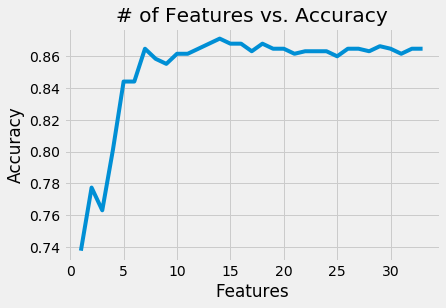

In [35]:
plt.plot(summary['# Features'], summary['Test Accuracy'])
plt.title("# of Features vs. Accuracy")
plt.xlabel("Features")
plt.ylabel("Accuracy")

Having determined that the top seven features were likely to have the largest impact on the quality of the classifier that I wanted to build, I set out to isolate these features and explore their relationship to the target in greater depth.

## Futher Exploration<a name="further"></a>

So, what were these features that gave the most insight into diabetes risk?

In [37]:
final = list(results['Features'])[:7]
final

['PCT_OBESE_ADULTS13',
 'PCT_SNAP12',
 'PCT_SBP09',
 'PCT_LACCESS_HHNV10',
 'SNAPSPTH12',
 'PCT_HISP10',
 'PCT_65OLDER10']

In [38]:
decode(final)

,Variable Code,Variable Name,Category Name,Subcategory Name,Units
13,PCT_LACCESS_HHNV10,"Households, no car & low access to store (%), ...",Access and Proximity to Grocery Store,Household Resources,Percent
68,SNAPSPTH12,"SNAP-authorized stores/1,000 pop, 2012",Store Availability,SNAP-authorized,"# per 1,000 pop"
96,PCT_SNAP12,"SNAP participants (% pop), 2012*",Food Assistance,SNAP,Percent
119,PCT_SBP09,"School Breakfast Program participants (% pop),...",Food Assistance,School Breakfast Program,Percent
254,PCT_OBESE_ADULTS13,"Adult obesity rate, 2013",Health and Physical Activity,Health,Percent
264,PCT_HISP10,"% Hispanic, 2010",Socioeconomic Characteristics,Race & Age,Percent
268,PCT_65OLDER10,"% Population 65 years or older, 2010",Socioeconomic Characteristics,Race & Age,Percent


Examining these features, I elected to group them into four categories for understanding:
1. **Obesity**
2. **Food Access**
3. **Food Assistance**
4. **Race & Age**

How then were these factors related to the diabetes belt? I set out to explore with the aid of boxplots. The function I used to make these plots may be found in my GitHub repository.

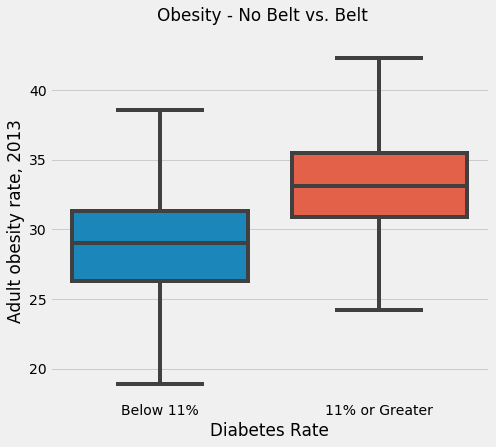

In [42]:
boxplotter(obesity, 1, 1, 'Obesity - No Belt vs. Belt')

Here, the relationship is clear. The median county diabetes rate in the Belt is at least 5% greater than outside of it.

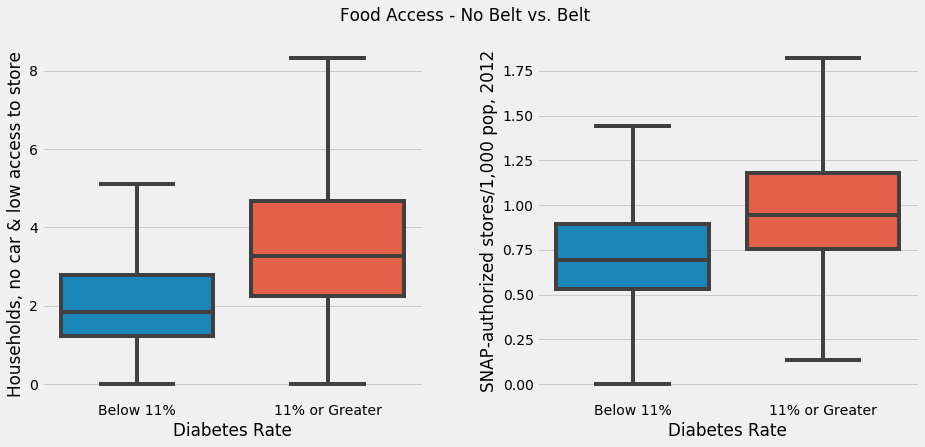

In [43]:
boxplotter(access, 1, 2, 'Food Access - No Belt vs. Belt')

Clearly, household access to store is an important factor, with **lower access overall in the belt.** SNAP-authorized stores may be thought of here as a **proxy for poverty**, as it is likely that there are more such stores in impoverished areas.

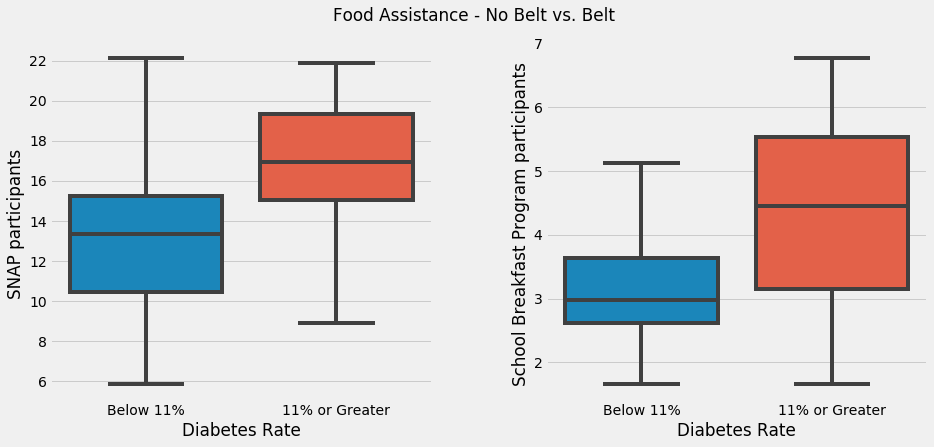

In [44]:
boxplotter(food_assist, 1, 2, 'Food Assistance - No Belt vs. Belt')

Again, these measures are probably best thought of as **proxies for poverty,** though it might take more domain knowledge to really know what is going on. Still, rates seem to be generally higher on the belt than off of it.

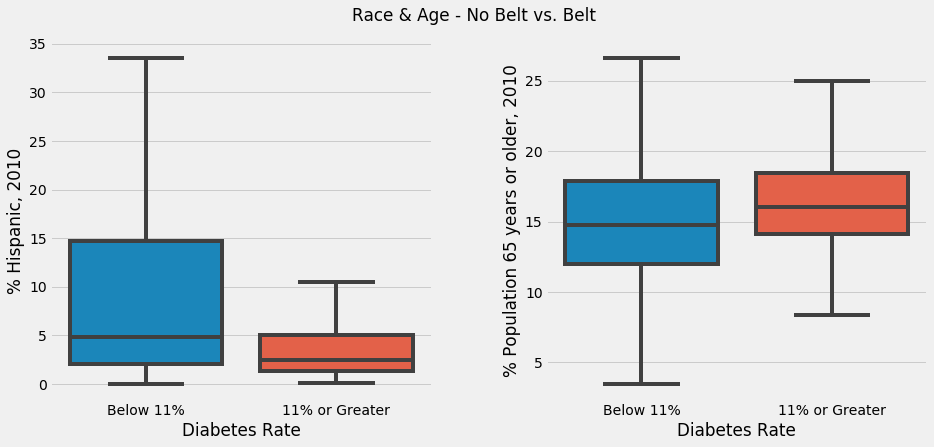

In [45]:
boxplotter(race_age, 1, 2, "Race & Age - No Belt vs. Belt")

Here, larger Hispanic populations were better represented off of the belt. Meanwhile, older populations were slightly better represented on the belt.

# Building a Classifier<a name="building"></a>

At this point, I felt comfortable taking a crack at developing a model. In order to do this, I built a pipeline to test four popular algorithms for classification:

1. Logistic Regression
2. Naive Bayes
3. Support Vector Machines
4. Random Forest

In [49]:
# instantiate our models
models = [
    ('Logistic Regression', LogisticRegression(solver='liblinear')),
    ('Naive Bayes', GaussianNB()),
    ('SVM', SVC(gamma='scale')),
    ('Random Forest', RandomForestClassifier(n_estimators=1000, n_jobs=-1))
]

In [50]:
results_accuracy = []
results_recall = []
names = []

# perform kfold validation on our data, applying each model 10 times and returning the means of the accuracy and recall scores
for name, model in models:
    names.append(name)
    
    kfold = model_selection.KFold(n_splits=10, random_state=1)
    cv_results_acc = model_selection.cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
    results_accuracy.append(cv_results_acc)

    cv_results_rec = model_selection.cross_val_score(model, X, y, cv=kfold, scoring='recall')
    results_recall.append(cv_results_rec)
    
    msg = "{}: Mean Accuracy: {}; Mean Recall: {}".format(name, np.mean(results_accuracy[-1]), np.mean(results_recall[-1]))
    print(msg)

Logistic Regression: Mean Accuracy: 0.7965726417955719; Mean Recall: 0.8002437773643095
Naive Bayes: Mean Accuracy: 0.7736639369123445; Mean Recall: 0.8481707175206757
SVM: Mean Accuracy: 0.800387220705692; Mean Recall: 0.7647862197476227
Random Forest: Mean Accuracy: 0.7914750783540592; Mean Recall: 0.7639746311963183


All four models did remarkably well. In order to get a clearer sense of what was going on, I produced boxplots of the individual scores from the kfold validation step.

![algorithm boxplots](/images/algorithm_comparison.png)

Surprisingly (to me), logistic regression performed the best overall of the four! Because it is a simple, fast algorithm that is robust against overfitting, and because the fact that it performed well probably means that the data is well-suited to what is essentially a linear approach, I felt comfortable selecting this as the final model with a **mean accuracy of 80%.**

Exploring the confusion matrix confirmed that the model was well-tuned for accuracy, with similar numbers of false positives and false negatives:

![logreg confusion matrix](/images/conf_logreg.png)

# Wrap-Up<a name="wrap"></a>

Given the wealth of data in the USDA's Food Environment Atlas, I have found that it is possible to construct a classifier that will determine whether a US county qualifies as a member of the CDC's Diabetes Belt with **~80% accuracy**.

The top categories of features appear to be **obesity, food access, food assistance, and race/age**. Some of these may be proxies for the effect of **poverty**, rather than causes in of themselves, but to assess this would require domain expertise and the investment of greater material resources.

I observed comparably excellent performance from all classifiers trialed, and ended up using **logistic regression**, which is fast, accurate in this case, and robust against overfitting.

## Recommendations<a name="recommendations"></a>

Based off of these findings, my recommendations to those who are working to identify diabetes hotspots in the US are as follows:

1. **A high rate of obesity in a county is the single best indicator for whether diabetes is likely to be a problem.** This is already well known, but it is valuable to know that these findings confirm that is the case.
2. **Vulnerable populations such as the elderly and families without transportation or easy access to stores are at a special risk for diabetes**, and where this demographic information is available, it is worth giving these populations special attention preemptively.
3. **Data on food access and socioeconomic factors are of demonstrable use in determining level of risk of diabetes in a county.** It is worth continuing to gather this data, and the more of it is available for public access, the better!

## Possible Next Steps<a name="possible"></a>

I feel confident that with more data and finer tuning, even more accurate models might be built from this data. Specifically, with more time to devote I would consider the following steps:

1. **More comprehensive hyperparameter tuning for SVM and Random Forest.** I ran a grid search on the hyperparameters for SVM, and tried a small group of different possibilities for Random Forest, but I could have done more, and might have wrung out better performance. I'm also curious about Bayesian hyperparameter optimization, and wonder whether that might lead me in a more fruitful direction.
2. **Engineering new features from multi-survey differences.** Features that consisted of the change of a measurement from one year or another could yield useful information about whether a particular county is trending better or worse, or perhaps whether or not it is the beneficiary of some kind of investment. While these are of questionable use as they are, as a transformed categorical variable, they might yield some fruit.
3. **Filling out features with null values instead of dropping them entirely.** There were a large number of interesting features that suffered from null values, which I did not consider when building this classifier. It might be interesting to see whether any of them provide useful enough information to be worth backfilling. Ultimately, my hope is that future USDA surveys will render this unnecessary.

Thank you for reading!

